In [1]:
%%time

### importing the library
from __future__ import print_function
import pandas as pd
import numpy as np
import seaborn as sns
import 

from scipy import signal

import matplotlib.pyplot as plt
%matplotlib inline 
import matplotlib.mlab as mlab
import urllib

import time

CPU times: user 2.1 s, sys: 481 ms, total: 2.58 s
Wall time: 4.96 s


In [2]:
%%time

url  = 'https://dcc.ligo.org/public/0002/T0900288/003/ZERO_DET_high_P.txt'
raw_data=urllib.request.urlopen(url)
ZERO_DET = np.loadtxt(raw_data)

CPU times: user 78 ms, sys: 14.3 ms, total: 92.2 ms
Wall time: 1.63 s


In [3]:
def oneSidedPeriodogram(y, fs):
    N = y.size
    yf = np.fft.fft(y)
    xf = np.fft.fftfreq(N, 1./fs)
    oneSidedPeriodogram = 2/fs*abs(yf[xf>=0])**2/N
    return yf, xf[xf>=0], oneSidedPeriodogram


def TimeseriesFromPSD(N = 8192, fs = 8192, fmin = 20, fmax = 4000):
    low_f_max = fmin
    high_f_min = fmax
    # Interpolation
    freqs = np.fft.fftfreq(N, 1./fs)
    asd_zero = np.interp(freqs[(freqs>=ZERO_DET[:,0].min())&(freqs<=high_f_min)], ZERO_DET[:,0], ZERO_DET[:,1]) 
    
    
    # Gauss noise and its one-sided PSD without window
    gauss_noise = 1* np.random.normal(loc=0,scale=64,size=N)
    _, xf_noise, psd_gauss = oneSidedPeriodogram(gauss_noise, fs)
    # psd_gauss ,xf_noise= plt.mlab.psd(gauss_noise, Fs=fs, NFFT=NFFT, window=psd_window, noverlap=NOVL)
    # xf_noise = xf_noise[1:]
    # psd_gauss = psd_gauss[1:]

    # Confirm the range of low frequency
#     shiftsize = 11
#     low_f_max = ZERO_DET[:,0].min() + shiftsize
#     high_f_min = 4000
    shiftsize = int(low_f_max - ZERO_DET[:,0].min())
    slc, slc_, slc__ = (xf_noise >= low_f_max)&(xf_noise<=high_f_min), (xf_noise < low_f_max), (xf_noise > high_f_min)

    # Two-sided PSD
    psd_twosided = np.hstack(( # low positive
                        psd_gauss[slc_] * 0
                       # high positive
                      , psd_gauss[slc][:] * (asd_zero**2)[shiftsize:]
                      , psd_gauss[slc__] * 0
                      , psd_gauss[slc__][::-1] * 0
                       # high negative
                      , psd_gauss[slc][:][::-1] *(asd_zero**2)[shiftsize:][::-1]
                       # low negative
                      , psd_gauss[slc_][::-1] * 0))

    np.random.seed()
    amplitude =  np.sqrt(psd_twosided *2 *fs*N )
    epsilon = np.random.rand(len(amplitude))*1j*2*np.pi
    return np.real(np.fft.ifft(amplitude*np.exp(epsilon))), psd_twosided   

In [4]:
%timeit TimeseriesFromPSD()

8.77 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [5]:
%%time 

TimeseriesFromPSD()

CPU times: user 4.19 ms, sys: 9.31 ms, total: 13.5 ms
Wall time: 10.5 ms


(array([  9.11084478e-22,  -4.75954614e-22,  -6.23799900e-22, ...,
         -1.67377394e-21,   1.02328481e-21,  -9.00782395e-22]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]))

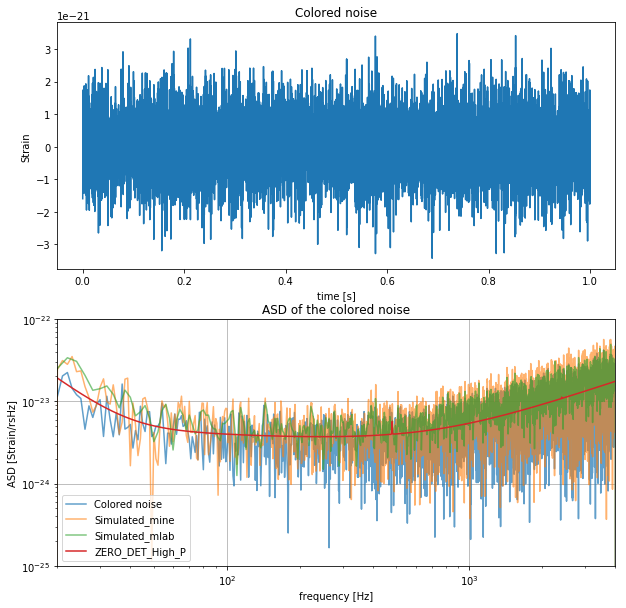

In [6]:
N = 8192
fs = 8192
fmin = 20
fmax = 4000

noise_sample, psd_zero = TimeseriesFromPSD(fmin=fmin, fmax=fmax)

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(np.linspace(0, N/fs, N), noise_sample)
plt.title('Colored noise')
plt.ylabel('Strain')
plt.xlabel('time [s]')


plt.subplot(2,1,2)
plt.loglog( np.sqrt(psd_zero[1:]), label = "Colored noise", alpha=0.7)

# Check#1
_, xf_noise_sample, PSD_noise_sample = oneSidedPeriodogram(noise_sample, fs)
plt.loglog(xf_noise_sample[1:], np.sqrt(PSD_noise_sample[1:]), label = "Simulated_mine", alpha=0.6)

# Check#2
NFFT = fs//2
# NFFT = 4*fs
psd_window = np.blackman(NFFT)
NOVL = NFFT/2
PSD_noise_sample ,xf_noise_sample= plt.mlab.psd(noise_sample, Fs=fs, NFFT=NFFT, window=psd_window, noverlap=NOVL)

plt.loglog(xf_noise_sample[1:], np.sqrt(PSD_noise_sample[1:]), label = "Simulated_mlab", alpha=0.6)
plt.loglog(ZERO_DET[:,0],ZERO_DET[:,1], label = "ZERO_DET_High_P")
plt.xlim(xmin=fmin, xmax = fmax)
plt.ylim((1e-25, 1e-22))
plt.title('ASD of the colored noise')
plt.ylabel('ASD [Strain/rsHz]')
plt.xlabel('frequency [Hz]')
plt.grid()
plt.legend()
plt.show()

- 蓝色 `Colored noise` 是生成有色噪声的过程中所参考的 ASD
- 橙色 `Simulated_mine` 是参考了我自己定义的 PSD 生成函数
- 绿色 `Simulated_mlab` 是参考了 MatLab 自带的 PSD 生成函数
- 红色 `ZERO_DET_High_P` 是 LIGO 官方提供的噪声参考 ASD

## Generate Noise

In [1]:
from data_utils import *
from data_noise import *

import mxnet as mx
import mxnet.ndarray as nd

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/Users/Herb/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:28: UserWarning: [Errno 28] No space left on device.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


/Users/Herb/github/Python4GW/data_noise.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  y[istart-1:yend,:] = y[istart-1:yend,:] + Y[:(yend-istart+1),:]


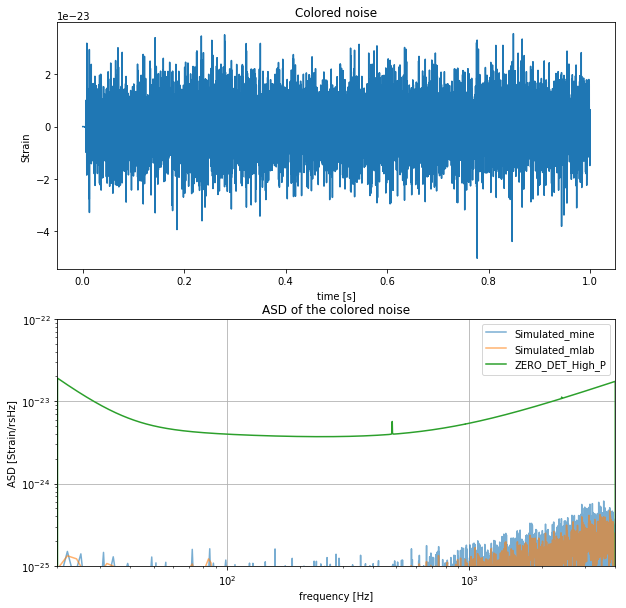

In [6]:
N = 8192
fs = 8192
fmin = 20
fmax = 4000

noise_sample = GenNoise_matlab(nDataSamples=N, fLow=fmin, fHigh=fmax, fs=fs, filtOrdr=100)

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(np.linspace(0, N/fs, N), noise_sample)
plt.title('Colored noise')
plt.ylabel('Strain')
plt.xlabel('time [s]')


plt.subplot(2,1,2)

# Check#1
_, xf_noise_sample, PSD_noise_sample = oneSidedPeriodogram(y=noise_sample, fs=fs)
plt.loglog(xf_noise_sample[1:], np.sqrt(PSD_noise_sample[1:]), label = "Simulated_mine", alpha=0.6)

# Check#2
NFFT = fs//2
# NFFT = 4*fs
psd_window = np.blackman(NFFT)
NOVL = NFFT/2
PSD_noise_sample ,xf_noise_sample= plt.mlab.psd(noise_sample, Fs=fs, NFFT=NFFT, window=psd_window, noverlap=NOVL)

plt.loglog(xf_noise_sample[1:], np.sqrt(PSD_noise_sample[1:]), label = "Simulated_mlab", alpha=0.6)
plt.loglog(ZERO_DET[:,0],ZERO_DET[:,1], label = "ZERO_DET_High_P")
plt.xlim(xmin=fmin, xmax = fmax)
plt.ylim((1e-25, 1e-22))
plt.title('ASD of the colored noise')
plt.ylabel('ASD [Strain/rsHz]')
plt.xlabel('frequency [Hz]')
plt.grid()
plt.legend()
plt.show()

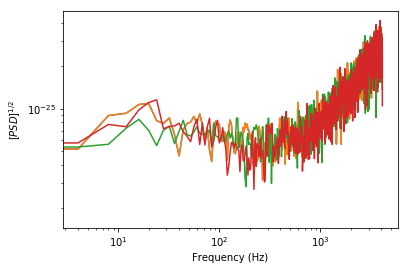

In [53]:
from scipy.signal import welch
[f, pxx] = welch(x = noise1,nperseg=2048, fs = 8192)
plt.loglog(f, np.sqrt(pxx))
[f, pxx] = welch(x = noise2[0],nperseg=2048, fs = 8192)
plt.loglog(f, np.sqrt(pxx))
[f, pxx] = welch(x = noise2[4],nperseg=2048, fs = 8192)
plt.loglog(f, np.sqrt(pxx))
[f, pxx] = welch(x = noise2[-1],nperseg=2048, fs = 8192)
plt.loglog(f, np.sqrt(pxx))
plt.xlabel('Frequency (Hz)')
plt.ylabel('$[PSD]^{1/2}$')
plt.show()

In [60]:
%timeit nd.random.normal(shape=(10000,8192), ctx = ctx)

88.4 µs ± 10.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [61]:
%timeit np.random.randn(10000, 8192)

3.94 s ± 64.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
%timeit GenNoise_matlab_np(shape = (1, 8192), b = b)

/Users/Herb/github/Python4GW/data_noise.py:195: ComplexWarning: Casting complex values to real discards the imaginary part
  y[istart-1:yend,:] = y[istart-1:yend,:] + Y[:(yend-istart+1),:]


2.08 ms ± 187 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [57]:
%timeit GenNoise_matlab_np(shape = (10000, 8192), b = b)

/Users/Herb/github/Python4GW/data_noise.py:195: ComplexWarning: Casting complex values to real discards the imaginary part
  y[istart-1:yend,:] = y[istart-1:yend,:] + Y[:(yend-istart+1),:]


25.7 s ± 3.74 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [216]:
b = pre_fir()
b = nd.array(b.reshape((-1,1)), ctx=ctx)

x = np.random.randn(10, 8192).T

In [217]:
m = x.shape[0]
if m == 1:
    x = x.reshape((-1,1))  # turn row into a column
nx = x.shape[0]

if min(b.shape) > 1:
    assert b.shape[1] == x.shape[1] and x.shape[1] <=1, "signal:fftfilt:InvalidDimensions"
else:
    b = b.reshape((-1,1))   # make input a column
nb = b.shape[0]
nfft = None
if nfft == None:
    # figure out which nfft and L to use
    if (nb >= nx) or (nb > 2**20):  # take a single FFT in this case
        nfft = int(2**round(np.log(nb+nx-1)/np.log(2)))
        L = nx
    else:
        fftflops = nd.array([ 18,59,138,303,660,1441,3150,6875,14952,32373,69762,
                            149647,319644,680105,1441974,3047619,6422736,13500637,
                            28311786,59244791,59244791*2.09])
        n = 2**nd.arange(1,22,1)
        validset_first = nd.argmax(n>nb-1,axis=0).asscalar()
        n = nd.slice(n, begin=[int(validset_first),], end=(None,))
        fftflops = nd.slice(fftflops, begin=[int(validset_first),], end=(None,))
        # minimize (number of blocks) * (number of flops per fft)
        L = n - (nb - 1)
        temp = nd.ceil(nx/L) * fftflops
        dum, ind = nd.min(temp), nd.argmin(temp, axis=0)
        nfft = int(n[int(ind.asscalar())].asscalar())
        L = int(L[int(ind.asscalar())].asscalar())

In [255]:
fft(b.asnumpy().T, nfft)

array([[  5.16722784e-24 +0.00000000e+00j,
          4.91862006e-24 -1.55821159e-24j,
          4.19968772e-24 -2.95775380e-24j, ...,
          3.08772858e-24 +4.05827175e-24j,
          4.19968772e-24 +2.95775380e-24j,
          4.91862006e-24 +1.55821159e-24j]])

In [262]:
tt = np.concatenate(( np.zeros((1,(nfft-b.size)//2)) ,b.asnumpy().T, np.zeros((1,(nfft-b.size)//2+1))) , axis=1)
print(fft(tt).shape)
fft(tt)

(1, 1024)


array([[  5.16722784e-24 +0.00000000e+00j,
         -5.15944226e-24 -3.16583385e-26j,
          5.13631298e-24 +6.30352078e-26j, ...,
         -5.09851225e-24 +9.38628400e-26j,
          5.13631298e-24 -6.30352078e-26j,
         -5.15944226e-24 +3.16583385e-26j]])

In [228]:
nd.contrib.fft(compute_size)

MXNetError: [17:49:16] src/operator/contrib/fft.cc:32: fft is only available for GPU.

Stack trace returned 10 entries:
[bt] (0) 0   libmxnet.so                         0x000000011707a3b4 libmxnet.so + 21428
[bt] (1) 1   libmxnet.so                         0x000000011707a16f libmxnet.so + 20847
[bt] (2) 2   libmxnet.so                         0x0000000117079de9 libmxnet.so + 19945
[bt] (3) 3   libmxnet.so                         0x00000001170e7e22 libmxnet.so + 470562
[bt] (4) 4   libmxnet.so                         0x00000001170e7e60 libmxnet.so + 470624
[bt] (5) 5   libmxnet.so                         0x000000011829c146 MXNDListFree + 1573094
[bt] (6) 6   libmxnet.so                         0x000000011717414e libmxnet.so + 1044814
[bt] (7) 7   libmxnet.so                         0x000000011817fe9b MXNDListFree + 409147
[bt] (8) 8   libmxnet.so                         0x00000001181843ae MXNDListFree + 426830
[bt] (9) 9   libmxnet.so                         0x00000001180f568a MXCustomFunctionRecord + 20250



In [26]:
m = 2
nx = 19
nb = 2
%timeit round(np.log(nb+nx-1)/np.log(2))
%timeit np.round(np.log(nb+nx-1)/np.log(2))

5.72 µs ± 639 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
11.1 µs ± 5.53 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [25]:
a = 6.7
%timeit round(a)
%timeit np.round(a)
%timeit nd.round(nd.array([a]))

346 ns ± 31.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
6.69 µs ± 298 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
179 µs ± 6.41 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [54]:
nd.exp([0, 1, 2])

AssertionError: Argument data must have NDArray type, but got [0, 1, 2]

In [113]:
n = 2**nd.arange(1,22,1)


AttributeError: 'numpy.float32' object has no attribute 'asscalar'

In [117]:
L = 3
np.ceil(nx/L)

7.0

In [112]:
validset_first = nd.argmax(n>nb-1,axis=0).asscalar()
nd.slice(n, begin=[int(validset_first),], end=(None,))


[  1.60000000e+01   3.20000000e+01   6.40000000e+01   1.28000000e+02
   2.56000000e+02   5.12000000e+02   1.02400000e+03   2.04800000e+03
   4.09600000e+03   8.19200000e+03   1.63840000e+04   3.27680000e+04
   6.55360000e+04   1.31072000e+05   2.62144000e+05   5.24288000e+05
   1.04857600e+06   2.09715200e+06]
<NDArray 18 @cpu(0)>

In [88]:
validset = np.nonzero(n.asnumpy() > nb-1)[0]
n[validset]


[  1.60000000e+01   3.20000000e+01   6.40000000e+01   1.28000000e+02
   2.56000000e+02   5.12000000e+02   1.02400000e+03   2.04800000e+03
   4.09600000e+03   8.19200000e+03   1.63840000e+04   3.27680000e+04
   6.55360000e+04   1.31072000e+05   2.62144000e+05   5.24288000e+05
   1.04857600e+06   2.09715200e+06]
<NDArray 18 @cpu(0)>

In [78]:
nd.argmax(n>nb-1,axis=0)


[ 3.]
<NDArray 1 @cpu(0)>

In [73]:
def fftfilt_nd(b, x, nfft=None):
    m = x.shape[0]
    if m == 1:
        x = x.reshape((-1,1))  # turn row into a column
    nx = x.shape[0]
    
    if min(b.shape) > 1:
        assert b.shape[1] == x.shape[1] and x.shape[1] <=1, "signal:fftfilt:InvalidDimensions"
    else:
        b = b.reshape((-1,1))   # make input a column
    nb = b.shape[0]
    print(nx,nb)
    if nfft == None:
        # figure out which nfft and L to use
        if (nb >= nx) or (nb > 2**20):  # take a single FFT in this case
            nfft = 2**round(np.log(nb+nx-1)/np.log(2))
            L = nx
        else:
            fftflops = nd.array([ 18,59,138,303,660,1441,3150,6875,14952,32373,69762,
                                 149647,319644,680105,1441974,3047619,6422736,13500637,
                                 28311786,59244791,59244791*2.09])
            n = 2**nd.arange(1,22,1)
            validset = np.nonzero(n > (nb -1))[0]   # must have nfft > (nb-1)
            n = n[validset]
            fftflops = fftflops[validset]
            # minimize (number of blocks) * (number of flops per fft)
            L = n - (nb - 1)
            temp = np.ceil(nx/L) * fftflops
            dum, ind = np.min(temp), np.argmin(temp)
            nfft = n[ind]
            L = L[ind]
            
    else:  # nfft is given
        # Cast to enforce precision rules
        pass
        raise 'nfft is given?'
        '''
        nfft = signal.internal.sigcasttofloat(nfft,'double','fftfilt','N','allownumeric');
        if nfft < nb
            nfft = nb;
        end
        nfft = 2.^(ceil(log(nfft)/log(2))); % force this to a power of 2 for speed
        L = nfft - nb + 1;        
        '''
    # Check the input data type. Single precision is not supported.
    '''
    try
        chkinputdatatype(b,x,nfft);
    catch ME
        throwAsCaller(ME);
    end'''

    B = fft(b.T, int(nfft)).T
    if b.size == 1:
        B = B.T     # make sure fft of B is a column (might be a row if b is scalar)
    if b.shape[1] == 1:
        B = np.repeat(B, [x.shape[1],],axis=1)    # replicate the column B 
    if x.shape[1] == 1:
        x = np.repeat(x, [b.shape[1],],axis=1)   # replicate the column x 
    y = np.zeros_like(x)
    print(nx)
    istart = 1
    while istart <= nx:
        iend = min(istart+L-1, nx)
        if (iend - istart) == 0:
            X = x[istart] * np.ones((nfft,1))  # need to fft a scalar
        else:
            X = fft(x[istart-1:iend,:].T, int(nfft)).T
        Y = ifft((X * B).T).T
        yend = min(nx,istart+nfft-1)
        y[istart-1:yend,:] = y[istart-1:yend,:] + Y[:(yend-istart+1),:]
        istart += L
    print(y, y.shape)
    y = real(y)
    if (m == 1) and (y.shape[1] == 1):
        y = y.T    # turn column back into a row
    return y

In [76]:
inputNoise = np.random.randn(10,8192)
outputNoise = fftfilt(b.reshape((1,-1)),inputNoise)

10 101
10
[[ -5.84668076e-28  -2.07109912e-28  -5.87078953e-28 ...,   5.63959170e-28
   -4.77657674e-29  -2.75411431e-28]
 [  2.67962263e-27  -8.62356036e-29   1.24112424e-27 ...,  -1.24254188e-27
    4.47921582e-28  -2.71343983e-29]
 [ -4.09063565e-27   1.02142025e-27   6.99107738e-28 ...,   5.29751586e-28
   -8.40183902e-28   2.05942371e-27]
 ..., 
 [  1.05486984e-26   2.59568547e-27   2.36459830e-27 ...,  -5.81833411e-27
   -9.42211805e-28   1.76623419e-27]
 [ -7.48314857e-27   3.99924323e-27  -3.33793247e-29 ...,   8.17096469e-28
    1.17838037e-27   2.37940196e-27]
 [  1.43315321e-26   5.10148649e-27   8.24346847e-28 ...,  -7.54361313e-27
    4.48190800e-28   3.43363487e-27]] (10, 8192)


/Users/Herb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: ComplexWarning: Casting complex values to real discards the imaginary part


In [82]:
shape = (10, 8192)
(numsamples, numsamplepoints) = shape
print(numsamples, numsamplepoints)

10 8192
